In [6]:
import os
import json
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aggregate_functions as agg
import plotting_functions as pf
import parse_facs_data as pfd
import statistical_tests as st
import importlib

In [7]:
young_data_root = '~/Data/HSC_aging_project/young_mice'
young_lb_file = os.path.join(young_data_root, 'lineage_bias/lineage_bias.csv')
young_abundance = pd.read_csv(
    os.path.join(young_data_root, "Ania_M_allAnia 10x hsc 8mice rerun8mice_Ania_percent-engraftment_NO filter_081019_long.csv")
)
young_lineage_bias = pd.read_csv(young_lb_file)

old_data_root = '~/Data/HSC_aging_project/aging_and_10x'
old_lb_file = os.path.join(old_data_root, 'lineage_bias/lineage_bias.csv')
old_abundance = pd.read_csv(
    os.path.join(old_data_root, "Ania_M_all OT2.0 rerun_percent-engraftment_NO filter_080819_long.csv")
)
old_lineage_bias = pd.read_csv(old_lb_file)

/Users/akre96/Documents/github/stemcell_aging/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
young_abundance = agg.filter_clones_threshold_anytime(
        young_abundance,
        {'any': 0.01},
        analyzed_cell_types=young_abundance.cell_type.unique(),
        filter_exempt_cell_types=['hsc']
    )
old_abundance = agg.filter_clones_threshold_anytime(
        old_abundance,
        {'any': 0.01},
        analyzed_cell_types=old_abundance.cell_type.unique(),
        filter_exempt_cell_types=['hsc']
    )
old_abundance['month'] = agg.day_to_month(old_abundance['day'])
young_abundance['month'] = agg.day_to_month(young_abundance['day'])

Filters: {'any': 0.01}
Change in length of abundanc post filtering: 0
Filters: {'any': 0.01}
Change in length of abundanc post filtering: 0


In [9]:
young_donor_file = os.path.join(
    young_data_root,
    'donor YO OTY 081019.txt'
)
young_gfp_file = os.path.join(
    young_data_root,
    'GFP YO OT 070819 updtd 081019 step7.txt'
)
young_wbc_file = os.path.join(
    young_data_root,
    'WBC 081019 step7.txt'
)
young_wbc = pfd.parse_wbc_count_file(
    young_wbc_file
)


old_donor_file = os.path.join(
    old_data_root,
    'aging_10x_Donor.txt'
)

old_gfp_file = os.path.join(
    old_data_root,
    'aging_10x_GFP.txt'
)

old_wbc_file = os.path.join(
    old_data_root,
    'aging_10x_WBC.txt'
)
old_wbc = pfd.parse_wbc_count_file(
    old_wbc_file
)

In [10]:
importlib.reload(agg)
b_min_abund = 0.05
myeloid_cell = 'gr'
lymphoid_cell = 'b'
timepoint_col = 'month'

young_lineage_bias = agg.filter_lineage_bias_cell_type_ratio_per_mouse(
    young_lineage_bias,
    timepoint_col,
    young_wbc,
    b_min_abund,
    myeloid_cell=myeloid_cell,
    lymphoid_cell=lymphoid_cell,
)
old_lineage_bias = agg.filter_lineage_bias_cell_type_ratio_per_mouse(
    old_lineage_bias,
    timepoint_col,
    old_wbc,
    b_min_abund,
    myeloid_cell=myeloid_cell,
    lymphoid_cell=lymphoid_cell,
)


 Filtering Lineage Bias Ratio Based on Gr/B Ratio Per Mouse at First Time Point
Length Before Filtering:  3018
Length After Filtering:  463 


 Filtering Lineage Bias Ratio Based on Gr/B Ratio Per Mouse at First Time Point
Length Before Filtering:  60958
Length After Filtering:  6026 



In [11]:
young_hsc_data = young_abundance[young_abundance.cell_type == 'hsc']
old_hsc_data = old_abundance[old_abundance.cell_type == 'hsc']

last_young_clones = agg.find_last_clones(
    young_lineage_bias,
    'day'
)
labeled_young_last_clones = agg.add_bias_category(
    last_young_clones
)
bias_young_hsc_abundance_df = young_hsc_data.merge(
    labeled_young_last_clones[['code', 'mouse_id', 'bias_category_short']],
    how='inner',
    validate='1:1'
).assign(age='young')


last_old_clones = agg.find_last_clones(
    old_lineage_bias,
    'day'
)
labeled_old_last_clones = agg.add_bias_category(
    last_old_clones
)
bias_old_hsc_abundance_df = old_hsc_data.merge(
    labeled_old_last_clones[['code', 'mouse_id', 'bias_category_short']],
    how='inner',
    validate='1:1'
).assign(age='old')

hsc_bias_abundance = bias_old_hsc_abundance_df.append(bias_young_hsc_abundance_df)



/Users/akre96/Documents/github/stemcell_aging/venv/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Text(0.5, 1.0, 'HSC Abundance by Bias at Last Time Point')

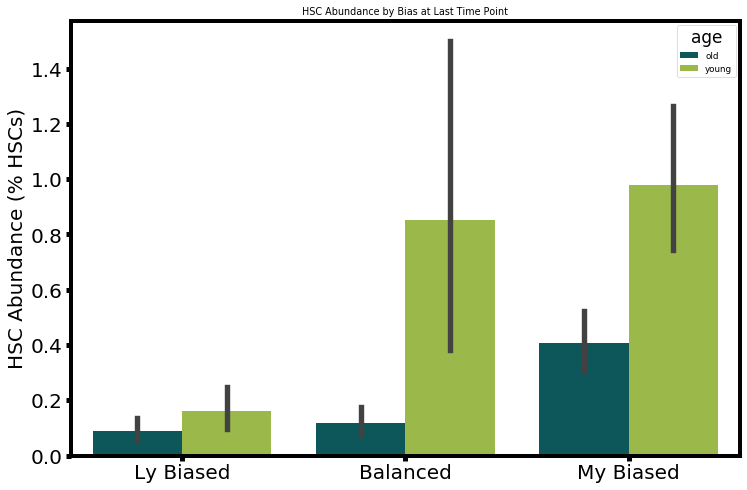

In [36]:
sns.set_context(
    'paper',
    rc={
        'lines.linewidth': 3,
        'axes.linewidth': 4,
        'axes.labelsize': 20,
        'xtick.major.width': 5,
        'ytick.major.width': 5,
        'ytick.minor.width': 5,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'figure.titlesize': 'small',
        'axes.edgecolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'figure.facecolor': 'white'
    }

    )
COLOR_PALETTES = json.load(open('lib/color_palettes.json', 'r'))
cats_order = [
    'Ly Biased',
    'Balanced',
    'My Biased',
]
unique_cats = list(OrderedDict.fromkeys(cats_order))


plt.figure(figsize=(12,8))
ax = sns.barplot(
    y='percent_engraftment',
    x='bias_category_short',
    order=unique_cats,
    data=hsc_bias_abundance,
    hue='age',
    palette=COLOR_PALETTES['age']
)
#ax.set(yscale='log')
plt.xlabel('')
plt.ylabel('HSC Abundance (% HSCs)')
plt.title(
    'HSC Abundance by Bias at Last Time Point'
)

In [8]:
import importlib
importlib.reload(st)
st.ranksums_test_group_time(
    data=hsc_bias_abundance,
    test_col='percent_engraftment',
    timepoint_col='bias_category_short',
    overall_context='Old vs Young Mice',
    show_ns=False,
    group_col='age'
)


Performing Ranksums Test on Old vs Young Mice between age at each Bias Category Short
Bias_Category_Short Balanced P-Value: 5.850763552972191e-14 Mean: -0.7348339021739132
Bias_Category_Short Ly Biased P-Value: 0.0020349160075549067 Mean: -0.07272125102229259
Bias_Category_Short My Biased P-Value: 7.853823787544784e-40 Mean: -0.5703686371681415

Performing Ranksums Test on Old vs Young Mice per age between Bias Category Shorts
Old Bias Category Short Balanced vs My Biased P-Value: 0.023463995094034698 Mean: -0.2920555150057715
Old Bias Category Short Balanced vs Ly Biased P-Value: 0.036218671899627415 Mean: 0.028003194086474767
Young Bias Category Short Balanced vs My Biased P-Value: 0.046673620463531955 Mean: -0.1275902499999998
Young Bias Category Short Balanced vs Ly Biased P-Value: 3.631961450444013e-07 Mean: 0.6901158452380953
Young Bias Category Short My Biased vs Ly Biased P-Value: 2.7127196056298306e-18 Mean: 0.8177060952380951
All Bias Category Short Balanced vs Ly Biased P-V

In [11]:
save_format='png'
fname = '/Users/akre96/Data/HSC_aging_project/young_mice/Graphs/' \
    + 'hsc_abundance_yvo' \
    + '.' + save_format

plt.savefig(
    fname,
    format=save_format,
    bbox_inches='tight',
)

<Figure size 432x288 with 0 Axes>

In [22]:
import scipy.stats as stats
import numpy as np

In [29]:
filt_old_abund = agg.remove_month_17_and_6(
    old_abundance,
    timepoint_col
)
old_hsc = filt_old_abund[filt_old_abund.cell_type == 'hsc'].rename(columns={'percent_engraftment': 'hsc_percent_engraftment'})
old_hsc = old_hsc[old_hsc.hsc_percent_engraftment > 0]
old_not_hsc = filt_old_abund[filt_old_abund.cell_type != 'hsc']

old_with_hsc = old_not_hsc.merge(
    old_hsc[['code','mouse_id', 'hsc_percent_engraftment']],
    on=['code', 'mouse_id'],
    how='inner',
    validate='m:1'
)

young_hsc = young_abundance[young_abundance.cell_type == 'hsc'].rename(columns={'percent_engraftment': 'hsc_percent_engraftment'})
young_hsc = young_hsc[young_hsc.hsc_percent_engraftment > 0]
young_not_hsc = young_abundance[young_abundance.cell_type != 'hsc']

young_with_hsc = young_not_hsc.merge(
    young_hsc[['code','mouse_id', 'hsc_percent_engraftment']],
    on=['code', 'mouse_id'],
    how='inner',
    validate='m:1'
)
young_with_hsc['age'] = 'young'
old_with_hsc['age'] = 'old'
with_hsc_data_df = young_with_hsc.append(old_with_hsc, ignore_index=True)

	 REMOVING MONTHS: 17, 6


In [30]:
pearson_df = pd.DataFrame()
for (cell_type, mouse_id, age, timepoint), t_df in with_hsc_data_df.groupby(['cell_type', 'mouse_id', 'age', timepoint_col]):
    pearson_r, p_value = stats.pearsonr(
        np.log10(1 + (t_df['percent_engraftment'] * 1000)),
        np.log10(1 + (t_df['hsc_percent_engraftment'] * 1000))
    )
    p_data = {
        'mouse_id': [mouse_id],
        'cell_type': [cell_type],
        timepoint_col: [timepoint],
        'pearson_r': [pearson_r],
        'p_value': [p_value],
        'age': [age]
    }
    pearson_df = pearson_df.append(pd.DataFrame.from_dict(p_data))


In [31]:
pearson_df.head()

,mouse_id,cell_type,month,pearson_r,p_value,age
0,M2012,b,9,-0.062648,0.776432,old
0,M2012,b,12,-0.001232,0.995547,old
0,M2012,b,15,-0.133699,0.543069,old
0,M2059,b,4,-0.167116,0.246057,old
0,M2059,b,9,-0.118141,0.413858,old


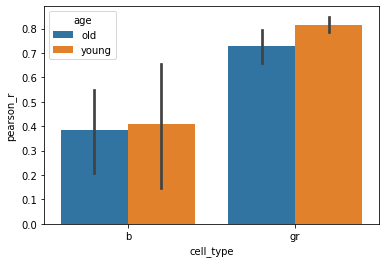

In [32]:
last_df = agg.find_last_clones(
    pearson_df,
    timepoint_col
)
sns.barplot(
    x='cell_type',
    y='pearson_r',
    hue='age',
    data=last_df
)

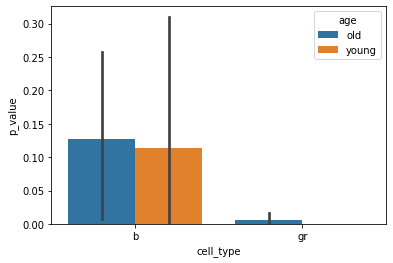

In [33]:
sns.barplot(
    x='cell_type',
    y='p_value',
    hue='age',
    data=last_df
)

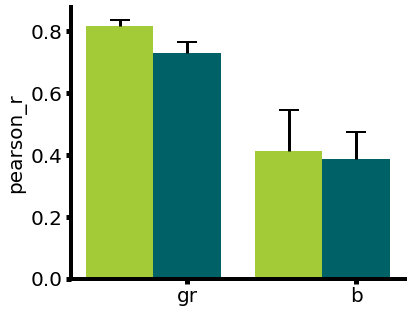

In [53]:
coords = np.arange(2)
width = 0.4
sems={}
means={}
cell_types = ['gr', 'b']
colors={}
value_col = 'pearson_r'
fig, ax = plt.subplots(figsize=(6,5))
i = -1
for age in ['young', 'old']:
    means[age]=[]
    colors[age]=[]
    sems[age] = [[], []]
    g_df = last_df[last_df.age == age]
    for c in cell_types:
        t_df = g_df[g_df['cell_type'] == c]
        sems[age][0].append(0)
        sems[age][1].append(t_df[value_col].sem())
        means[age].append(t_df[value_col].mean())
        colors[age].append(COLOR_PALETTES['age'][age])
        
    ax.bar(
        x=coords + (i*width/2),
        height=means[age],
        width=width,
        tick_label=cell_types,
        color=colors[age],
    )

    _, caps, _ = ax.errorbar(
        coords + (i*width/2),
        means[age],
        yerr=sems[age],
        color='black',
        capsize=10,
        capthick=2,
        ls='none',
        )
    i = i * -1
    caps[0].set_marker('_')
    caps[0].set_markersize(0)
ax.set_ylabel(value_col)
sns.despine()

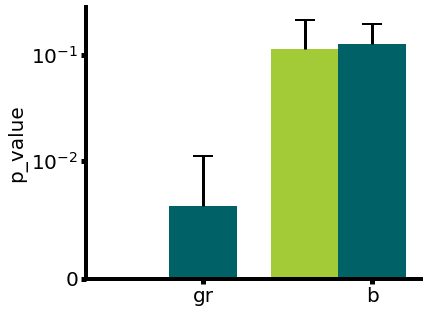

In [54]:
coords = np.arange(2)
width = 0.4
sems={}
means={}
cell_types = ['gr', 'b']
colors={}
value_col = 'p_value'
fig, ax = plt.subplots(figsize=(6,5))
ax.set_yscale('symlog', linthreshy=10e-3)
i = -1
for age in ['young', 'old']:
    means[age]=[]
    colors[age]=[]
    sems[age] = [[], []]
    g_df = last_df[last_df.age == age]
    for c in cell_types:
        t_df = g_df[g_df['cell_type'] == c]
        sems[age][0].append(0)
        sems[age][1].append(t_df[value_col].sem())
        means[age].append(t_df[value_col].mean())
        colors[age].append(COLOR_PALETTES['age'][age])
        
    ax.bar(
        x=coords + (i*width/2),
        height=means[age],
        width=width,
        tick_label=cell_types,
        color=colors[age],
    )

    _, caps, _ = ax.errorbar(
        coords + (i*width/2),
        means[age],
        yerr=sems[age],
        color='black',
        capsize=10,
        capthick=2,
        ls='none',
        )
    i = i * -1
    caps[0].set_marker('_')
    caps[0].set_markersize(0)
ax.set_ylabel(value_col)
sns.despine()